# KNN SVM LSTM GRU WITH ENSEMBLE

# SEPARATE CODE

In [1]:
import csv
import copy
import argparse
import itertools
from collections import Counter
from collections import deque
import pandas as pd
import cv2
import seaborn as sns
import numpy as np
import mediapipe as mp
import time
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,mean_squared_error, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical



In [2]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def show(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        return elapsed_time
    def stop(self):
        self._start_time=None

In [3]:
# Function to calculate landmark list
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Iterate over each landmark point
    for _, landmark in enumerate(landmarks.landmark):
        # Convert normalized coordinates to pixel coordinates
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z  # Uncomment this line if you need the z-coordinate

        # Append the pixel coordinates to the landmark_point list
        landmark_point.append([landmark_x, landmark_y])

    return landmark_point


# Function to preprocess landmarks
def pre_process_landmark(landmark_list):
    # Implement your preprocessing logic here
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list
    pass


# To Load A Label

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0)  # Use the appropriate index or video file path
keyy = 1
t = Timer()
while keyy != 0:
    label = input("Enter label")
    label=" "+label
    with open("label.txt",'r') as f:
        la=f.read().split()
        size=len(la)
        print(size)
    with open('label.txt','a+') as f:
        print(f.read())
        f.write(label)
    t.start()
    while t.show() < 120.0 and cap.isOpened():
        ret, frame = cap.read()

        # BGR 2 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Flip on horizontal
        image = cv2.flip(image, 1)
        debug_image = copy.deepcopy(image)

        # Set flag
        image.flags.writeable = False

        # Detections
        results = hands.process(image)

        # Set flag to true
        image.flags.writeable = True

        # RGB 2 BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Rendering results
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                l=pre_process_landmark(landmark_list)
                l.insert(0,size)
                #print("Iterations:",l)
                #print(pre_processed_landmark_list)
                x, y, w, h = cv2.boundingRect(np.array(landmark_list))
                cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                hand_label = "Left Hand" if handedness.classification[0].label == "Left" else "Right Hand"
                cv2.putText(debug_image, hand_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                mp_drawing.draw_landmarks(debug_image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                          )
                with open("training_data.csv",'a+',newline='') as f:
                    writer=csv.writer(f)
                    #print(l)
                    writer.writerow(l)
    keyy = int(input("Continue?"))
    t.stop()

cap.release()
cv2.destroyAllWindows()
hands.close()

In [4]:
labels_file = 'label.txt'
with open(labels_file, 'r') as f:
    labels = f.read().split()

data_file = 'training_data.csv'
unique_words = set()
with open(data_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        unique_words.update(row)

word_index = {word: index for index, word in enumerate(unique_words)}
label_index_mapping = {label: index for index, label in enumerate(labels)}
print(label_index_mapping)

{'open': 0, 'close': 1, 'pointer': 2, 'ok': 3, 'iloveyou': 4, 'Good': 5, 'Bad': 6, 'Peace': 7, 'Super': 8, 'Pray': 9, 'Stop': 10, 'Call': 11, 'Love': 12, 'No': 13, 'thank': 14, 'you': 15, 'Internet': 16, 'House': 17, 'food': 18, 'Chicken': 19, 'When': 20, 'What': 21, 'TV': 22, 'A': 23, 'alphabet_A': 24, 'alphabet_B': 25, 'alphabet_C': 26, 'alphabet_D': 27, '1': 28, 'alphabet_L': 29, 'alphabet_H': 30, 'alphabet_F': 31, 'alphabet_J': 32, 'alphabet_W': 33, 'alphabet_V': 34, 'alphabet_v': 35, 'alphabet_X': 36, '4': 37}


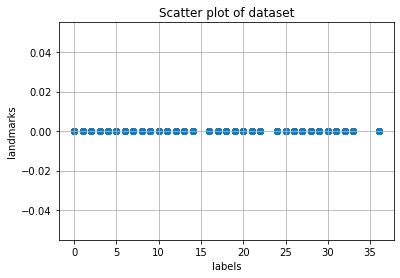

In [5]:
data=pd.read_csv('training_data.csv',header=None)
data.head()
plt.scatter(data[0],data[1])
plt.xlabel('labels')
plt.ylabel('landmarks')
plt.title('Scatter plot of dataset')
plt.grid(True)
plt.show()

# To Train the data

In [6]:
y=data.iloc[:,0]
x=data.iloc[:,1:]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.20,random_state=77)

In [7]:
y.shape

(32590,)

In [8]:
x.shape

(32590, 42)

In [9]:
xtrain.shape

(26072, 42)

In [10]:
xtest.shape

(6518, 42)

In [11]:
ytrain.shape

(26072,)

In [12]:
ytest.shape

(6518,)

In [13]:
y.axes

[RangeIndex(start=0, stop=32590, step=1)]

In [14]:
x.axes

[RangeIndex(start=0, stop=32590, step=1),
 Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
             18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
             35, 36, 37, 38, 39, 40, 41, 42],
            dtype='int64')]

In [15]:
y.size


32590

In [16]:
x.size

1368780

# Normalizing the data

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

# To calculate accuracy for KNN

Accuracy for K-NN Algorithm -- >  98.95673519484505  %

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       291
           1       0.98      0.99      0.98       315
           2       0.97      0.99      0.98       255
           3       0.99      1.00      0.99        68
           4       1.00      1.00      1.00        20
           5       0.98      0.98      0.98        88
           6       1.00      0.99      0.99        86
           7       0.97      0.99      0.98        70
           8       0.98      0.95      0.97       103
           9       0.98      1.00      0.99        57
          10       0.99      1.00      0.99        83
          11       0.99      0.99      0.99        92
          12       0.99      1.00      1.00       107
          13       0.97      0.95      0.96        81
          14       0.98      0.99      0.99       150
          16       1.00      1.00      1.00       612
  

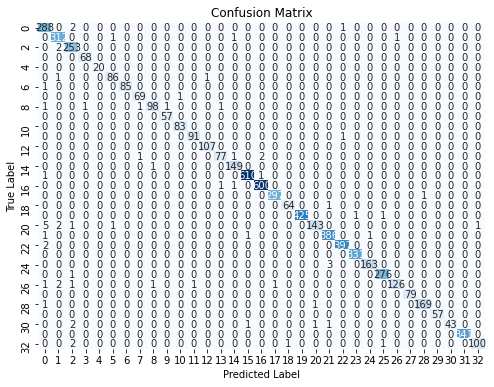

In [18]:
#Neighbours = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain,ytrain)
pred=knn.predict(xtest)
acc=knn.score(xtest,ytest)
print("Accuracy for K-NN Algorithm -- > ",acc*100," %")

print("\nClassification Report:")
print(classification_report(ytest, pred))
cm = confusion_matrix(ytest, pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

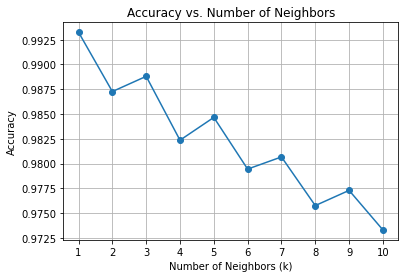

In [24]:
neighbors = list(range(1, 11))  # You can adjust this range as needed
accuracies = []
for k in neighbors:
    # Initialize KNN classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the model
    knn.fit(xtrain, ytrain)
    pred = knn.predict(xtest)
    # Calculate accuracy and append to list
    acc = accuracy_score(ytest, pred)
    accuracies.append(acc)
# Plot the graph
plt.plot(neighbors, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(neighbors)
plt.grid(True)
plt.show()

# To calculate accuracy for SVM

In [19]:
clf = svm.SVC()
clf.fit(xtrain,ytrain)
spred=clf.predict(xtest)
sacc=clf.score(xtest,ytest)
print("Accuracy for SVM Algoritm -- > ",sacc*100, "%")

print("\nClassification Report:")
print(classification_report(ytest, spred))

Accuracy for SVM Algoritm -- >  96.85486345504756 %

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       291
           1       0.91      0.97      0.94       315
           2       0.93      0.95      0.94       255
           3       1.00      0.99      0.99        68
           4       1.00      0.90      0.95        20
           5       0.98      0.94      0.96        88
           6       0.99      0.97      0.98        86
           7       1.00      0.99      0.99        70
           8       0.98      0.95      0.97       103
           9       1.00      1.00      1.00        57
          10       0.97      1.00      0.98        83
          11       1.00      0.99      0.99        92
          12       1.00      0.94      0.97       107
          13       0.97      0.81      0.89        81
          14       0.97      0.97      0.97       150
          16       1.00      0.99      0.99       612
     

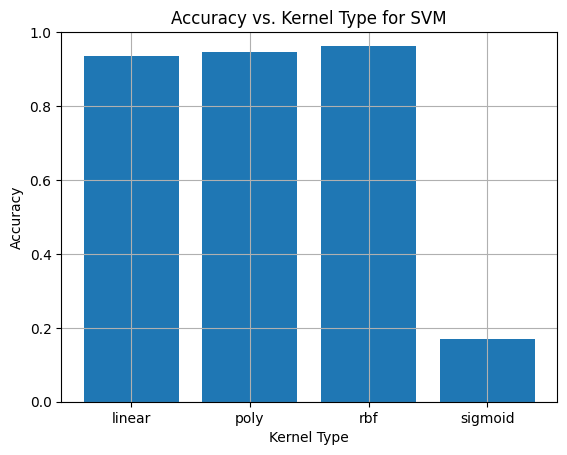

In [31]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
# Initialize lists to store accuracy scores
accuracies = []
# Loop through different kernel types
for kernel in kernels:
    # Initialize SVM classifier with the specified kernel
    clf = svm.SVC(kernel=kernel)
    clf.fit(xtrain, ytrain)
    spred = clf.predict(xtest)
    sacc = accuracy_score(ytest, spred)
    accuracies.append(sacc)
plt.bar(kernels, accuracies)
plt.title('Accuracy vs. Kernel Type for SVM')
plt.xlabel('Kernel Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits to better visualize differences
plt.grid(True)
plt.show()

# To Calculate accuracy for LSTM

In [20]:
# Reshape input data for LSTM
y=to_categorical(y)
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.20,random_state=0)

xtrain_lstm = xtrain_scaled.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest_lstm = xtest_scaled.reshape((xtest.shape[0], xtest.shape[1], 1))

In [21]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='linear', input_shape=(42,1)))
model.add(LSTM(128, return_sequences=True, activation='linear'))
model.add(LSTM(64, return_sequences=False, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(37, activation='softmax'))

In [22]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 42, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 42, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 37)                1221      
                                                                 
Total params: 172581 (674.14 KB)
Trainable params: 17258

In [26]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [27]:
yt=ytrain.reshape(-1,1)
ytrain.shape

(26072, 37)

In [28]:
# Train the model for lstm
history = model.fit(xtrain, ytrain, epochs=20, batch_size=64, validation_data=[xtest,ytest], verbose=1)

Epoch 1/5
408/408 [==============================] - 79s 194ms/step - loss: 0.3327 - accuracy: 0.9055 - val_loss: 0.3010 - val_accuracy: 0.9210
Epoch 2/5
408/408 [==============================] - 84s 206ms/step - loss: 0.2895 - accuracy: 0.9157 - val_loss: 0.2888 - val_accuracy: 0.9274
Epoch 3/5
408/408 [==============================] - 82s 201ms/step - loss: 0.2599 - accuracy: 0.9229 - val_loss: 0.2339 - val_accuracy: 0.9362
Epoch 4/5
408/408 [==============================] - 83s 203ms/step - loss: 0.2257 - accuracy: 0.9344 - val_loss: 0.1997 - val_accuracy: 0.9509
Epoch 5/5
408/408 [==============================] - 85s 208ms/step - loss: 0.2147 - accuracy: 0.9367 - val_loss: 0.1896 - val_accuracy: 0.9498


In [31]:
best_model = load_model('best_model.h5')

In [30]:
# Evaluate on test data lstm
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy BiLSTM: {test_accuracy:.4f}")

204/204 [==============================] - 9s 43ms/step - loss: 0.1896 - accuracy: 0.9498
Test Loss: 0.1896, Test Accuracy BiLSTM: 0.9498


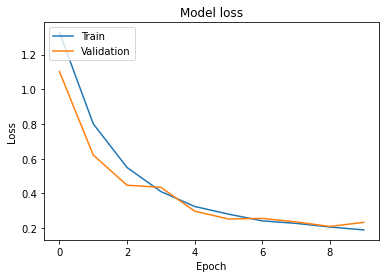

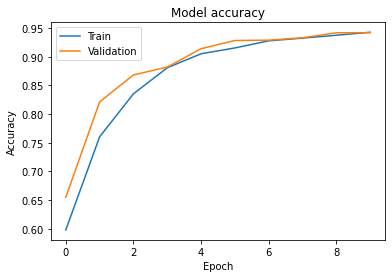

In [16]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# To Calculate accuracy for GRU

In [32]:
xtrain_gru = xtrain_scaled.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest_gru = xtest_scaled.reshape((xtest.shape[0], xtest.shape[1], 1))

model = Sequential()
model.add(GRU(64, return_sequences=True, activation='linear', input_shape=(42,1)))
model.add(GRU(128, return_sequences=True, activation='linear'))
model.add(GRU(64, return_sequences=False, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(37, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 42, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 42, 128)           74496     
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 37)                1221      
                                                                 
Total params: 132069 (515.89 KB)
Trainable params: 132

In [37]:
checkpoint = ModelCheckpoint('best_model_gru.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [34]:
# Train the model for gru
history = model.fit(xtrain, ytrain, epochs=20, batch_size=64, validation_data=[xtest,ytest], verbose=1)

Epoch 1/5
204/204 [==============================] - 65s 271ms/step - loss: 2.7207 - accuracy: 0.2375 - val_loss: 1.9283 - val_accuracy: 0.4491
Epoch 2/5
204/204 [==============================] - 54s 267ms/step - loss: 1.0402 - accuracy: 0.7073 - val_loss: 0.5006 - val_accuracy: 0.8641
Epoch 3/5
204/204 [==============================] - 54s 266ms/step - loss: 0.4003 - accuracy: 0.8877 - val_loss: 0.3469 - val_accuracy: 0.9020
Epoch 4/5
204/204 [==============================] - 55s 269ms/step - loss: 0.2893 - accuracy: 0.9190 - val_loss: 0.2402 - val_accuracy: 0.9402
Epoch 5/5
204/204 [==============================] - 54s 266ms/step - loss: 0.2134 - accuracy: 0.9438 - val_loss: 0.2000 - val_accuracy: 0.9435


In [38]:
# Evaluate on test data gru
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy GRU: {test_accuracy:.4f}")

204/204 [==============================] - 7s 36ms/step - loss: 0.2000 - accuracy: 0.9435
Test Loss: 0.2000, Test Accuracy GRU: 0.9435


In [ ]:
best_model = load_model('best_model_gru.h5')

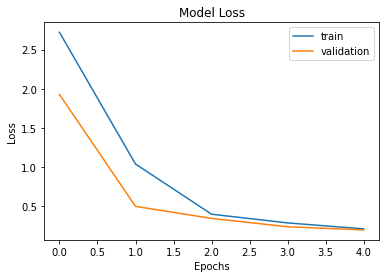

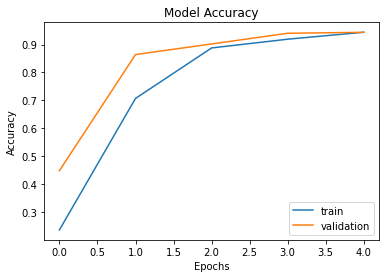

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# For Realtime Prediction

In [41]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5)
cap = cv2.VideoCapture(0)  # Use the appropriate index or video file path

recognition_times_knn = []  # To store recognition times for k-NN
recognition_times_svm = []  # To store recognition times for SVM
recognition_times_lstm = [] #To store recognition times for LSTM
recognition_times_gru = [] #To store recognition times for GRU


print("K-NN \t SVM \t BiLSTM \t GRU")
while cap.isOpened():
    ret, frame = cap.read()

    # BGR 2 RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Flip on horizontal
    image = cv2.flip(image, 1)
    debug_image = copy.deepcopy(image)

    # Set flag
    image.flags.writeable = False

    # Detections
    results = hands.process(image)

    # Set flag to true
    image.flags.writeable = True

    # RGB 2 BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    with open("label.txt",'r') as f:
        label=f.read().split()
        # Rendering results
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                    landmark_list = calc_landmark_list(debug_image, hand_landmarks)
                    pre_processed_landmark_list = pre_process_landmark(landmark_list)
                    x, y, w, h = cv2.boundingRect(np.array(landmark_list))
                    cv2.rectangle(debug_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    hand_label = "Left Hand" if handedness.classification[0].label == "Left" else "Right Hand"
                    cv2.putText(debug_image, hand_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                    mp_drawing.draw_landmarks(debug_image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                                  mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                                  )
            data2 = pd.DataFrame([pre_processed_landmark_list])
            xi = data2.iloc[:,:]

            start_time = time.perf_counter()               #Record start time

            # Predict using k-NN
            pred = knn.predict(xi)
            #pred_knn = knn.predict([pre_processed_landmark_list])[0]
            end_time = time.perf_counter()                  # Record end time and calculate recognition time
            recognition_time_knn = end_time - start_time
            recognition_times_knn.append(recognition_time_knn)

            # Predict using SVM
            spred=clf.predict(xi)
            end_time = time.perf_counter()                 # Record end time and calculate recognition time
            recognition_time_svm = end_time - start_time
            recognition_times_svm.append(recognition_time_svm)

            # Predict using LSTM
            xi_lstm = np.array(xi).reshape((xi.shape[0], xi.shape[1],1))  # Reshape for LSTM input
            predictions_prob = model.predict(xi_lstm)
            pred_lstm = np.argmax(predictions_prob,axis=1)
            end_time = time.perf_counter()  # Record end time and calculate recognition time
            recognition_time_lstm = end_time - start_time
            recognition_times_lstm.append(recognition_time_lstm)

            # Predict using GRU
            xi_gru = np.array(xi).reshape((xi.shape[0], xi.shape[1], 1))  # Reshape for GRU input
            predictions_prob = model.predict(xi_gru)
            pred_gru = np.argmax(predictions_prob, axis=1)
            end_time = time.perf_counter()  # Record end time and calculate recognition time
            recognition_time_gru = end_time - start_time
            recognition_times_gru.append(recognition_time_gru)

            op=label[int(pred)]  #knn
            sop=label[int(spred)] #svm
            lop = label[int(pred_lstm)]  # biLSTM
            gop = label[int(pred_gru)]  # GRU
            print(" ")
            print(op, "\t", sop, "\t", lop, "\t", gop)

            predictions = [op, sop, lop, gop]  # Ensemble predicition
            max_vote = max(set(predictions), key=predictions.count)
            print("\nEnsemble Prediction:", max_vote)
            print(" ")

            time.sleep(1)
            cv2.putText(debug_image,str(op), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 255, 255), 2)
            time.sleep(1)
            cv2.imshow('Hand Tracking', debug_image)

            if cv2.waitKey(400) & 0xFF == ord('q'):
                break
print(" ")
# Calculate and print average recognition time for k-NN
avg_recognition_time_knn = sum(recognition_times_knn) / len(recognition_times_knn)
print("Average Recognition Time (k-NN):", avg_recognition_time_knn*1000, "ms")

# Calculate and print average recognition time for SVM
avg_recognition_time_svm = sum(recognition_times_svm) / len(recognition_times_svm)
print("Average Recognition Time (SVM):", avg_recognition_time_svm*1000, "ms")

# Calculate and print average recognition time for LSTM
avg_recognition_time_lstm = sum(recognition_times_lstm) / len(recognition_times_lstm)
print("Average Recognition Time (BiLSTM):", avg_recognition_time_lstm * 100, "ms")

# Calculate and print average recognition time for GRU
avg_recognition_time_gru = sum(recognition_times_gru) / len(recognition_times_gru)
print("Average Recognition Time (GRU):", avg_recognition_time_gru * 100, "ms")

cap.release()
cv2.destroyAllWindows()
hands.close()


K-NN 	 SVM 	 BiLSTM 	 GRU
1/1 [==============================] - 0s 58ms/step
 
open 	 open 	 alphabet_A 	 alphabet_A

Ensemble Prediction: alphabet_A
 
1/1 [==============================] - 0s 79ms/step
 
Peace 	 Peace 	 Peace 	 Peace

Ensemble Prediction: Peace
 
1/1 [==============================] - 0s 32ms/step
 
Stop 	 open 	 pointer 	 pointer

Ensemble Prediction: pointer
 
1/1 [==============================] - 0s 26ms/step
 
Internet 	 open 	 TV 	 TV

Ensemble Prediction: TV
 
1/1 [==============================] - 0s 25ms/step
 
open 	 open 	 alphabet_C 	 alphabet_C

Ensemble Prediction: alphabet_C
 
1/1 [==============================] - 0s 37ms/step
 
open 	 open 	 open 	 open

Ensemble Prediction: open
 
1/1 [==============================] - 0s 23ms/step
 
Stop 	 Stop 	 Stop 	 Stop

Ensemble Prediction: Stop
 
1/1 [==============================] - 0s 24ms/step
 
Stop 	 Stop 	 Stop 	 Stop

Ensemble Prediction: Stop
 
1/1 [==============================] - 0s 32ms/step
 
